In [727]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root,):
    """
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    nodes, edges = trace(root)
    dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'})

    for n in nodes:
        dot.node(name=str(id(n)), label="{%s | data %.4f  | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:

import math


class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out


    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()
    
    def tanh(self):
        #np.tanh() works but 0 dep go!!
        val = self.data
        t = (math.exp(2*val) - 1) / (math.exp(2*val)  + 1)
        out = Value(t,(self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad

        out._backward = _backward
        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [729]:


import random


class Neuron:
    def __init__(self,nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        activation = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return activation.tanh()
    
    def paramters(self):
        return self.w + [self.b]

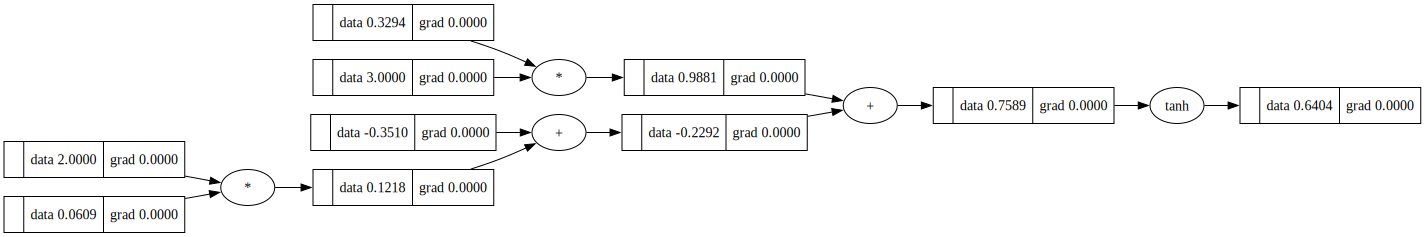

In [730]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)
draw_dot(n(x))

In [731]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs =  [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.paramters()]

In [732]:
x = [2.0, 3.0]
n = Layer(2,3)
n(x)

[Value(data=0.975670943850336, grad=0),
 Value(data=0.8527257972915108, grad=0),
 Value(data=0.298682162042742, grad=0)]

In [733]:
class MLP:
    def __init__(self, nin, nouts):
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

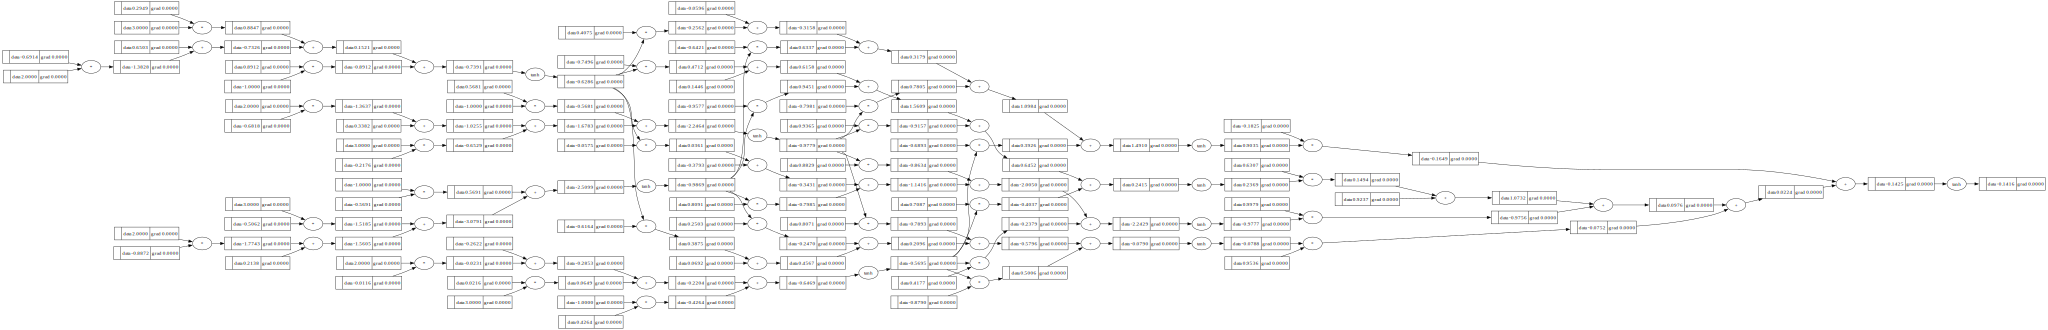

In [734]:
x = [2.0, 3.0, -1.0]
n  = MLP(3,[4,4,1])
n(x)
draw_dot(n(x))

In [735]:
#Sample data set
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Value(data=-0.14157603073673344, grad=0),
 Value(data=0.05802625584725059, grad=0),
 Value(data=0.09205085154870489, grad=0),
 Value(data=-0.08178068402964213, grad=0)]

In [736]:
#Loss -  single number used to measure how well the nn is performing for the traning data

loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)])
loss.backward()
#draw_dot(loss)

In [737]:
ypred = [n(x) for x in xs]
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)])
loss

Value(data=4.785439902722679, grad=0)

In [738]:
loss.backward()

In [739]:

learn_rate = +0.01
for p in n.parameters():
    p.data += learn_rate * p.grad


In [740]:
ypred

[Value(data=-0.14157603073673344, grad=-2.283152061473467),
 Value(data=0.05802625584725059, grad=2.1160525116945013),
 Value(data=0.09205085154870489, grad=2.1841017030974097),
 Value(data=-0.08178068402964213, grad=-2.1635613680592845)]

In [741]:
for k in range(20000):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)])

    if loss.data < 0.001:
        break

    for p in n.parameters():
        p.grad = 0.0
    
    #backward pass
    loss.backward()

    learn_rate = -0.05
    for p in n.parameters():
        p.data += learn_rate * p.grad



In [742]:
loss

Value(data=0.0009999634760245555, grad=0)

In [743]:
ypred

[Value(data=0.9849716006804573, grad=0),
 Value(data=-0.9829585677723235, grad=0),
 Value(data=-0.9856439717444856, grad=0),
 Value(data=0.9833385255672463, grad=0)]

In [745]:
xtest = [3.0, -1.0, 0.5]
n(xtest)

Value(data=-0.9829585677723235, grad=0)